# Importing libraries

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Lambda
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import random

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/A3

Mounted at /content/drive
/content/drive/MyDrive/A3


# Set random seed

In [2]:
import os
import numpy as np
import tensorflow as tf
import random

# Set environment variables
os.environ['PYTHONHASHSEED'] = str(25)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Set seed values
np.random.seed(25)
tf.random.set_seed(25)
random.seed(25)

# TODO: Preprocess

In [3]:
# Preprocess the text
def preprocess(text):
    # TODO
    words = text.split()
    words = [word.lower() for word in words]

    return words

# TODO: Build Vocabulary and training data

In [4]:
# TODO: Build vocabulary and generate training data
def build_and_prepare_data(words, window_size=2):
    vocabulary = {}
    for word in words:
        if word not in vocabulary:
            vocabulary[word] = len(vocabulary)
    reverse_vocabulary = {v: k for k, v in vocabulary.items()}
    vocab_size = len(vocabulary)

    # Generate context-target pairs
    data = []
    for i in range(window_size, len(words) - window_size):
        context = words[i-window_size:i] + words[i+1:i+window_size+1]
        target = words[i]
        data.append((context, target))

    # Extract contexts and targets from data
    contexts = []
    targets = []
    for context, target in data:
        context_indices = [vocabulary[word] for word in context]
        target_index = vocabulary[target]
        contexts.append(context_indices)
        targets.append(target_index)

    contexts = np.array(contexts)
    targets = np.array(targets)

    # Prepare targets for training by one-hot encoding
    targets = tf.keras.utils.to_categorical(targets, num_classes=vocab_size)

    return vocabulary, contexts, targets

# TODO: Build CBOW model

In [5]:
# Define CBOW model function
def build_cbow_model(vocab_size, embed_size, window_size):
    context_size = 2 * window_size

    # Input layer for context words
    context_inputs = Input(shape=(context_size,), name="context_inputs")

    # Embedding layer
    embedding = Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=context_size, name="embedding")
    context_vectors = embedding(context_inputs)

    # Averaging layer
    average_context = Lambda(lambda x: tf.reduce_mean(x, axis=1), name="average")(context_vectors)

    # Output layer with softmax
    output = Dense(vocab_size, activation='softmax', name="output")(average_context)

    # Construct the model
    model = Model(inputs=context_inputs, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# TODO: Set file path

In [6]:
# TODO: set correct file path
file_path = 'small_corpus.txt'

# Running the helper functions

In [7]:
# Read the file
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

words = preprocess(text)

# Print vocabulary size
print(f"Number of words: {len(words)}")

# Model parameters
window_size = 2

# Prepare dataset
vocab, contexts, targets = build_and_prepare_data(words, window_size)

vocab_size = len(vocab)
# Print vocabulary size
print(f"Vocabulary size: {vocab_size}")

# Print lengths of contexts and targets
print(f"Length of contexts array: {len(contexts)}")
print(f"Length of targets array: {len(targets)}")

Number of words: 280000
Vocabulary size: 28
Length of contexts array: 279996
Length of targets array: 279996


# Split the data inton training and validation sets

In [8]:
# Splitting the data
contexts_train, contexts_val, targets_train, targets_val = train_test_split(contexts, targets, test_size=0.2, random_state=25)

embed_size = 2

# Train the model

In [9]:
# Create and train the model
model = build_cbow_model(28, embed_size, window_size)
history = model.fit(contexts_train, targets_train, validation_data=(contexts_val, targets_val), epochs=7, verbose=1)
model.summary()

Epoch 1/7
7000/7000 [==============================] - 27s 4ms/step - loss: 2.3511 - accuracy: 0.1167 - val_loss: 2.2244 - val_accuracy: 0.1292
Epoch 2/7
7000/7000 [==============================] - 17s 2ms/step - loss: 2.2122 - accuracy: 0.1392 - val_loss: 2.2059 - val_accuracy: 0.1416
Epoch 3/7
7000/7000 [==============================] - 18s 3ms/step - loss: 2.2018 - accuracy: 0.1442 - val_loss: 2.2000 - val_accuracy: 0.1462
Epoch 4/7
7000/7000 [==============================] - 16s 2ms/step - loss: 2.1942 - accuracy: 0.1489 - val_loss: 2.1919 - val_accuracy: 0.1509
Epoch 5/7
7000/7000 [==============================] - 16s 2ms/step - loss: 2.1863 - accuracy: 0.1527 - val_loss: 2.1858 - val_accuracy: 0.1513
Epoch 6/7
7000/7000 [==============================] - 22s 3ms/step - loss: 2.1810 - accuracy: 0.1542 - val_loss: 2.1819 - val_accuracy: 0.1546
Epoch 7/7
7000/7000 [==============================] - 16s 2ms/step - loss: 2.1778 - accuracy: 0.1540 - val_loss: 2.1792 - val_accuracy:

# TODO: Visualise the Training and Validation loss

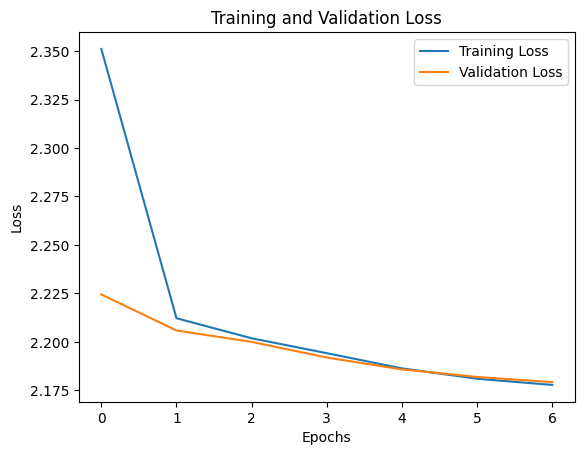

In [10]:
# Plotting the training and validation loss
#TODO
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# TODO: Extract the embeddings

In [11]:
# Extract embeddings
#TODO
def extract_embeddings(model, vocab):
    # Get the weights of the embedding layer
    embeddings = model.get_layer('embedding').get_weights()[0]

    # Create a dictionary mapping words to their embeddings
    word_embeddings = {word: embeddings[index] for word, index in vocab.items()}
    return word_embeddings

embeddings = extract_embeddings(model, vocab)
for word, embedding in embeddings.items():
    print(f"{word}: {embedding}")

morocco: [-1.8107634  2.284674 ]
algeria: [-9.13221    2.8675044]
kenya: [-4.61058    2.3788106]
nigeria: [-4.3329134  2.022174 ]
ghana: [-0.69275117  2.3782167 ]
egypt: [-1.1584285 -0.6396671]
tanzania: [-2.8446586  5.0101514]
uganda: [-3.2628355  6.699494 ]
ethiopia: [-2.8730211  4.720761 ]
indonesia: [ 7.088971  -0.7378336]
bangladesh: [3.134454  1.4567496]
india: [9.036944  2.6886306]
thailand: [4.5503798 3.113456 ]
japan: [1.4471004 1.6456051]
vietnam: [ 1.2970668 -0.618826 ]
malaysia: [ 3.6853416 -1.1638845]
china: [2.3558478  0.91227627]
philippines: [2.1839683 2.8975644]
germany: [-0.18234634 -2.7802205 ]
uk: [-0.22027062 -1.9850616 ]
spain: [-1.9887996 -3.9666572]
italy: [-4.901821  -2.4017134]
russia: [ 0.41294986 -3.4421425 ]
netherlands: [-0.42719075 -4.8662314 ]
switzerland: [-0.43319952 -2.8791475 ]
sweden: [ 0.5199303 -1.7424269]
france: [-0.31572628 -3.505221  ]
poland: [ -1.3898699 -11.583425 ]


# TODO: Find similar words

In [12]:
def cosine_similarity(vec_a, vec_b):
    """Calculate the cosine similarity between two vectors."""
    #TODO
    dot_product = np.dot(vec_a, vec_b)
    norm_a = np.linalg.norm(vec_a)
    norm_b = np.linalg.norm(vec_b)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

def find_similar_words(query_word, vocab, embeddings, top_n=3):
    """Find the top_n words most similar to the query_word based on the embeddings."""
    if query_word not in vocab:
        print(f"'{query_word}' is not in the vocabulary.")
        return

    query_embedding = embeddings[query_word]

    similarities = []

    for word, embedding in embeddings.items(): # Iterate over word, embedding pairs
        if word == query_word:
            continue
        similarity = cosine_similarity(query_embedding, embedding)
        similarities.append((word, similarity))

    # Sort based on similarity scores
    similarities.sort(key=lambda x: x[1], reverse=True)

    # Print top similar words
    print(f"Words most similar to '{query_word}':")
    for word, similarity in similarities[:top_n]:
        print(f"{word}: {similarity:.4f}")



In [13]:
query_words = ['sweden', 'thailand', 'uganda','poland','morocco']

for query_word in query_words:
    find_similar_words(query_word, vocab, embeddings)
    print("\n")


Words most similar to 'sweden':
russia: 0.9855
germany: 0.9375
netherlands: 0.9296


Words most similar to 'thailand':
bangladesh: 0.9864
china: 0.9735
japan: 0.9691


Words most similar to 'uganda':
tanzania: 0.9980
ethiopia: 0.9956
ghana: 0.9856


Words most similar to 'poland':
uk: 1.0000
france: 0.9996
switzerland: 0.9996


Words most similar to 'morocco':
ethiopia: 0.9924
tanzania: 0.9882
uganda: 0.9766




# TODO: Visualise the embeddings

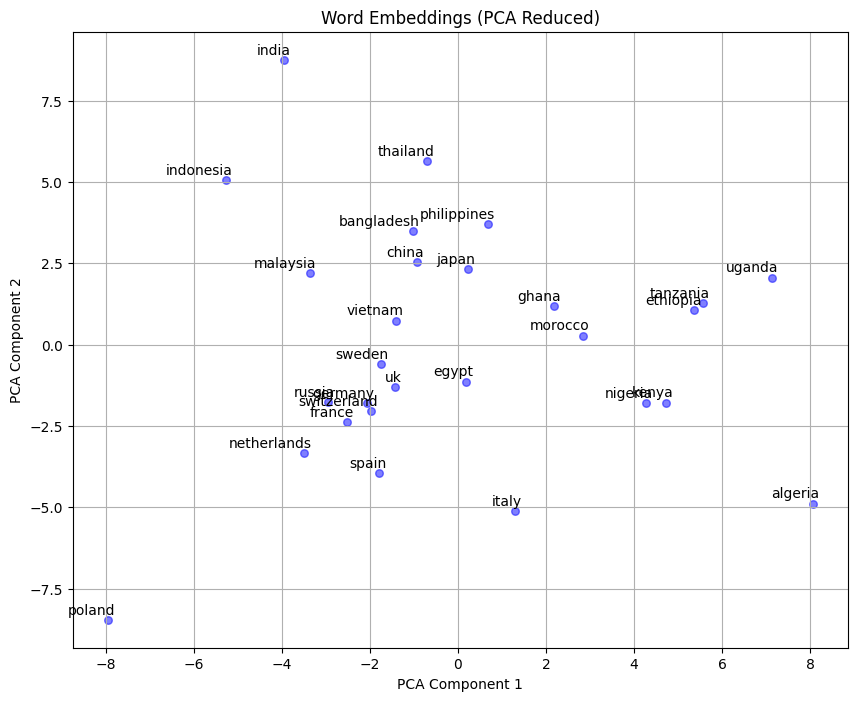

In [14]:
from sklearn.decomposition import PCA

# Create a scatter plot of the embeddings
# TODO

words = list(vocab.keys())
vectors = np.array([embeddings[word] for word in words])

# Reduce dimensionality of embeddings using PCA
pca = PCA(n_components=2)
vectors_pca = pca.fit_transform(vectors)

# Create scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(vectors_pca[:, 0], vectors_pca[:, 1], marker='o', s=30, c='blue', alpha=0.5)

# Add annotations for each point
for word, (x, y) in zip(words, vectors_pca):
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

plt.title('Word Embeddings (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()